In [2]:
import pandas as pd
import numpy as np 

import sys
sys.path.append('../../Function/')
import function

from keras.layers import Dense, Dropout
from keras.models import Sequential


In [3]:
df = pd.read_excel('../../../site_info_ver_5.xlsx')

In [4]:
dataset = df.copy()
sites = dataset.Site_Name.unique()
site_name = 'Makhtesh Ramon'
target = 'Israelis_Count'
target_title = 'Israelis'
dataset = dataset.loc[dataset.Site_Name==site_name]
# dataset = dataset.loc[dataset[target]<2000]

dataset = dataset.drop(['Total','Tourists_Count'],axis=1)
dataset = function.remove_pollution_site(dataset)
dataset = dataset.drop(dataset.filter(regex='nox').columns, axis=1)
dataset = dataset.drop(dataset.filter(regex='so2').columns, axis=1)
print('model on site',site_name)
print('Focus on ',target_title)

# dataset = function.remove_outliers(dataset, target)

dataset = function.remove_unique_one(dataset)
dataset = function.remove_high_corr(dataset, target,0.4)
dataset = function.split_date(dataset)
dataset = function.get_weekday(dataset)
dataset = function.last_year_entries_info(dataset,target)
# dataset.set_index("Date",inplace=True)
dataset.drop("Date",axis=1,inplace=True)
dataset = dataset.astype({'day': 'category'})
dataset = dataset.astype({'month': 'category'})
dataset = dataset.astype({'year': 'category'})
dataset = dataset.drop('day', axis=1)
print(dataset.dtypes)
print(dataset.shape)
dataset = pd.get_dummies(dataset)

print('shape of dataset',dataset.shape)
print('features :',dataset.columns)
dataset[['Israelis_Count']].describe()

remove pollution site Successfully
model on site Makhtesh Ramon
Focus on  Israelis
Add Last year visitors Successfully
is_weekend                     int64
operations                     int64
is_jewish_holiday              int64
is_muslims_holiday             int64
Haifa_pm10_exceeded            int64
Beer-Sheva_pm10_exceeded       int64
Haifa_pm2.5_exceeded           int64
Ashkelon_pm2.5_exceeded        int64
Season_autumn                  int64
Season_spring                  int64
Season_summer                  int64
month                       category
year                        category
Friday                         uint8
Monday                         uint8
Saturday                       uint8
Sunday                         uint8
Thursday                       uint8
Tuesday                        uint8
Wednesday                      uint8
Last_year_visitors           float64
Israelis_Count                 int64
dtype: object
(1507, 22)
shape of dataset (1507, 37)
features : Ind

,Israelis_Count
count,1507.000000
mean,288.143995
std,182.805025
min,7.000000
25%,155.000000
50%,246.000000
75%,374.500000
max,1085.000000


In [5]:
dataset = function.move_target_to_last(dataset, 'Israelis_Count')

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X = dataset.drop(target,axis=1)
y = dataset[target]
# X.drop(['Date','Tel_Aviv-Yafo_nox_exceeded','Season_spring','Season_autumn','Season_summer','Season_winter','Jerusalem_nox_exceeded'],axis=1,inplace=True)
# X.drop(['Date'],axis=1,inplace=True)
# X = X.drop(X.filter(regex='exceeded').columns, axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

X_train_scaler = MinMaxScaler()
X_test_scaler = MinMaxScaler()

X_train_scaled = X_train_scaler.fit_transform(X_train)
X_test_scaled = X_test_scaler.fit_transform(X_test)

y_train_scaled = np.log(y_train+0.001)
y_test_scaled = np.log(y_test+0.001)

dataset_train = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
dataset_test = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)



rmse 4873935638751897.0
std 167.22287716499804
(-2.564031566134183e+16, 'Season_summer')
(-2.2906801634746668e+16, 'month_10')
(-2.2906801634746612e+16, 'month_11')
(-2.113226162731763e+16, 'month_5')
(-2.113226162731753e+16, 'month_3')
(-2.11322616273175e+16, 'month_4')
(-1.823596682541412e+16, 'month_1')
(-1.8235966825413988e+16, 'month_12')
(-1.8235966825413984e+16, 'month_2')
(-1.1218785217746718e+16, 'year_2017')
(-1.1218785217746718e+16, 'year_2018')
(-1.1218785217746714e+16, 'year_2016')
(-1.1218785217746684e+16, 'year_2019')
(-77.068, 'is_muslims_holiday')
(-9.59, 'Haifa_pm10_exceeded')
(-6.084, 'Ashkelon_pm2.5_exceeded')
(0.0, 'year_2020')
(12.535, 'Haifa_pm2.5_exceeded')
(22.05, 'Beer-Sheva_pm10_exceeded')
(23.562, 'operations')
(67.117, 'Last_year_visitors')
(173.01, 'is_jewish_holiday')
(457814416656331.1, 'is_weekend')
(2795600402457473.5, 'Saturday')
(2795600402457495.0, 'Friday')
(2896294801903524.0, 'Season_spring')
(3253414819113912.0, 'Monday')
(3253414819113915.5, 'W

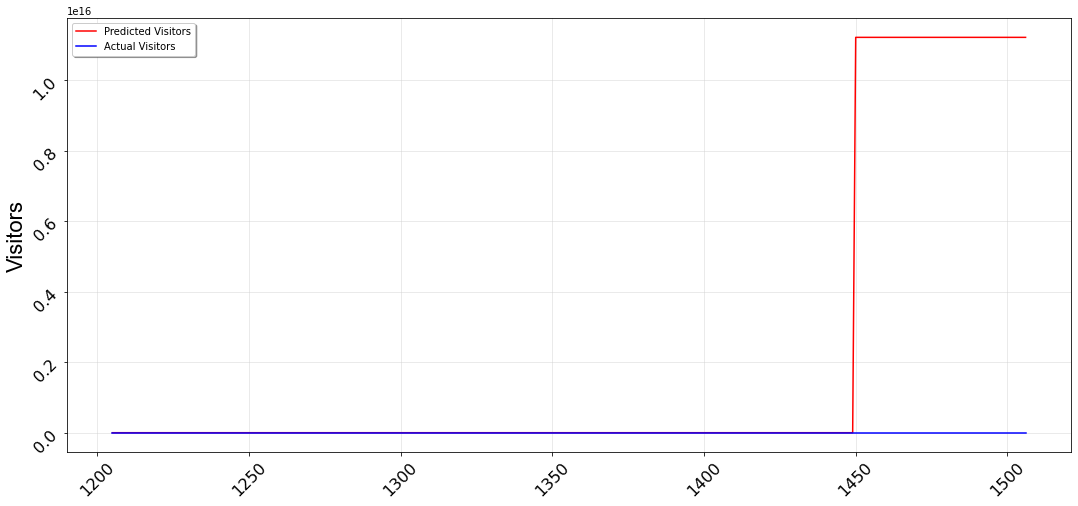

In [7]:
from sklearn.linear_model import LinearRegression

mlr = LinearRegression()
mlr.fit(X_train_scaled,y_train)

prediction =mlr.predict(X_test_scaled)

res = pd.DataFrame(
    data={
        'Prediction':prediction,
        'Actual': y_test.values
    },
    index=y_test.index
)

print('rmse',function.get_rmse(res.Prediction, res.Actual))
print('std',np.std(res.Actual))

coef = sorted( list(zip(np.round(mlr.coef_,3).T,X_train.columns)))
for x in coef:
    print(x)
res.sort_index(inplace=True)
function.plot_line(res.Prediction, res.Actual)


mae 115.75627683172162
rmse 156.7209282716144
std 167.22287716499804


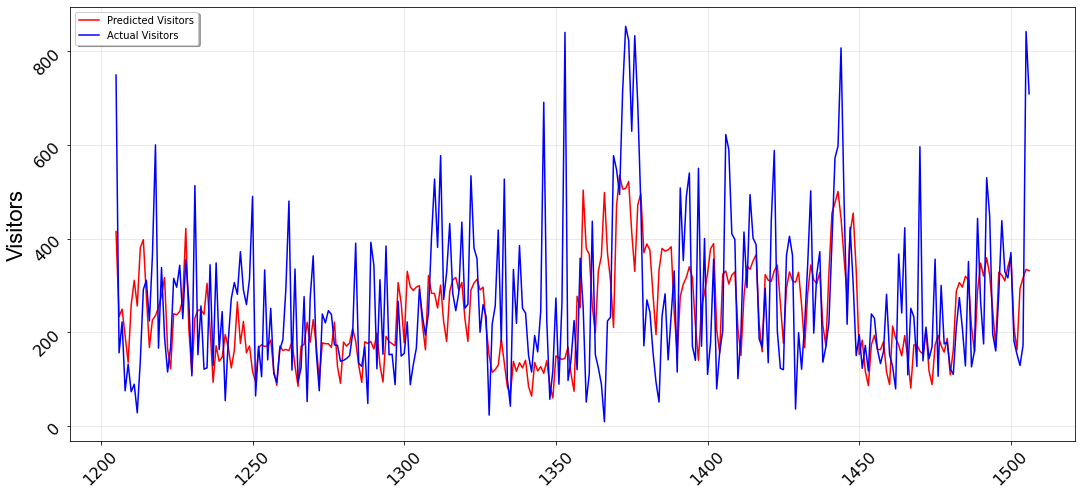

,Prediction,Actual
1205,414.924438,749
1206,233.406784,156
1207,249.151001,222
1208,192.821579,75
1209,135.662521,132
1210,258.323578,73
1211,310.748749,89
1212,256.029510,28
1213,380.375000,138
1214,397.527588,291


In [8]:
from keras import backend
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from IPython.display import clear_output
from keras.regularizers import l2
from sklearn.metrics import mean_absolute_error

# create ANN model
model = Sequential()
 
model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(518,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))


# model.add(Dense(np.sqrt(X_train.shape[1] * 3),activation='tanh'))
# model.add(Dropout(0.2))
# model.add(Dense(np.sqrt(X_train.shape[1] * 3),activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1))
 
# Compiling the model
model.compile(metrics=['mae','accuracy'], optimizer='adam', loss = 'mean_squared_error')
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=25, verbose=1 )
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0 )
mcp = ModelCheckpoint(filepath='weights_Ramon.h5', monitor='val_loss', verbose=1 , save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train_scaled, y_train, shuffle=True, epochs=1000,verbose=0 ,callbacks=[es, rlr, mcp, tb],validation_split=0.2,batch_size=1)
clear_output(True)
model.load_weights('weights_Ramon.h5')
prediction =model.predict(X_test_scaled)
print('')
res2 = pd.DataFrame(
    data={
        'Prediction':prediction.T[0],
        'Actual': y_test.values
    },
    index=y_test.index
)
print('mae', mean_absolute_error(res2.Prediction, res2.Actual))
print('rmse',function.get_rmse(res2.Prediction, res2.Actual))
print('std',np.std(res2.Actual))

res2.sort_index(inplace=True)
function.plot_line(res2.Prediction, res2.Actual)
# function.plot_residuals(res2.Prediction, res2.Actual)
res2.head(10)

In [9]:
rmse_str = str(np.round(function.get_rmse(res2.Prediction, res2.Actual),2))
import os 
# Check whether the specified path exists or not
path = site_name+'/'+rmse_str
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)
model.save(path)

INFO:tensorflow:Assets written to: Makhtesh Ramon/156.72\assets


In [10]:
from keras.models import load_model
model = load_model('./Makhtesh Ramon/151.31')

In [11]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 37)                1406      
                                                                 
 dropout_12 (Dropout)        (None, 37)                0         
                                                                 
 dense_21 (Dense)            (None, 512)               19456     
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 1024)              525312    
                                                                 
 dropout_14 (Dropout)        (None, 1024)              0         
                                                                 
 dense_23 (Dense)            (None, 1)                

In [12]:
from lime_stability.stability import LimeTabularExplainerOvr

class_names=['Israelis_Count']

feature_index_list_selected=np.array(np.arange(12))
categorical_features = np.argwhere(
    np.array([len(set(X_train.values[:,x]))
    for x in range(X_train.shape[1])]) <= 10).flatten()
print(X_train.columns.shape)
print(categorical_features.shape)
print(X_train.shape)
explainer = LimeTabularExplainerOvr(X_train_scaled,
 feature_names=X_train.columns,
 class_names=class_names, 
 categorical_features=categorical_features, 
 verbose=True, mode='regression',feature_selection='auto',feature_index_list_selected=feature_index_list_selected
 )

exp = explainer.explain_instance(X_test_scaled[2],model.predict,num_features=len(feature_index_list_selected))
exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()
exp.save_to_file('makhtesh_ramon_results.html')

(36,)
(35,)
(1205, 36)
lime_stability -- __init__ :feature_index_list_selected [ 0  1  2  3  4  5  6  7  8  9 10 11]
LimeTabularExplainer -- __init__ :feature_index_list_selected [ 0  1  2  3  4  5  6  7  8  9 10 11]


ValueError: in user code:

    File "c:\Users\asars\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\asars\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\asars\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\asars\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "c:\Users\asars\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\asars\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 37), found shape=(None, 36)
